In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots, COLORMAPS
from collections import Counter
from matplotlib.lines import Line2D
from aging.organization.dataframes import load_male_long_df, load_female_long_df, DF_PATHS
from tqdm import tqdm

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
import random
from sklearn.metrics import accuracy_score

In [3]:
cmm = COLORMAPS.ont_male
cmf = COLORMAPS.ont_female
m_df = load_male_long_df(average_weeks=True, merge_size=False, merge_ages=True, df_path=DF_PATHS.usage_male).groupby(['age','mouse']).mean()
f_df = load_female_long_df(average_weeks=True, merge_size=False, filter_female=True, merge_ages=True, df_path=DF_PATHS.usage_female).groupby(['age','mouse']).mean()
m_df['sex'] = 'm'
m_df.set_index('sex', inplace = True, append=True)
f_df['sex'] = 'f'
f_df.set_index('sex', inplace = True, append=True)

# Combine male and female data into a single DataFrame
combined_df = pd.concat([m_df, f_df])
#combined_df.set_index('sex', inplace=True, append=True)

In [4]:
format_plots()

In [5]:
# Parameters
N_SPLIT = 5
N_REP = 20
N_SHUFFLE = 100
WINDOW_SIZE = 8

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=10, kernel='linear'))
])

# Function to perform rolling window analysis using a pipeline
def rolling_window_classification(df, pipeline, window_size=8):
    results = []
    shuffle_results = []
    ages = df.index.get_level_values('age').unique()
    
    for i in tqdm(range(len(ages) - window_size + 1), desc="Rolling Window Classification Progress"):
        window_ages = ages[i:i + window_size]
        window_data = df.loc[df.index.get_level_values('age').isin(window_ages)]
        center_age = np.mean(window_ages)
        
        for sex in np.unique(window_data.index.get_level_values('sex')):
            sex_data = window_data[window_data.index.get_level_values('sex') == sex]
            X_sex = sex_data.values
            y_sex = sex_data.index.get_level_values('mouse')
            
            # Original classification
            for j in range(N_REP):
                skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=j)
                y_pred = cross_val_predict(pipeline, X_sex, y_sex, cv=skf, n_jobs=-1)
                results.append((center_age, accuracy_score(y_sex,y_pred), sex))
             
            # Shuffled classifications
            for j in range(N_SHUFFLE):
                y_shuffled = np.random.permutation(y_sex)
                skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=j)
                y_pred_shuff = cross_val_predict(pipeline, X_sex, y_shuffled, cv=skf, n_jobs=-1)
                shuffle_results.append((center_age, accuracy_score(y_shuffled,y_pred_shuff), sex))
    
    return results, shuffle_results

# Run the rolling window classification for combined data
results, shuffle_results = rolling_window_classification(combined_df, pipeline, window_size=WINDOW_SIZE)
results_df = pd.DataFrame(results, columns=['age', 'accuracy', 'sex'])
shuffle_df = pd.DataFrame(shuffle_results, columns=['age', 'accuracy', 'sex'])

Rolling Window Classification Progress:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 24/39 [01:48<01:02,  4.16s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

Rolling Window Classification Progress:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 27/39 [02:01<00:50,  4.20s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

Rolling Window Classification Progress:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 31/39 [02:20<00:35,  4.39s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Rolling Window Classification Progress:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 34/39 [02:34<00:22,  4.59s/it]/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has

In [10]:
temp = shuffle_df.query('sex=="m"')

In [11]:
temp['age'].value_counts()

age
6.500     100
36.500    100
29.125    100
30.250    100
31.375    100
32.500    100
33.500    100
34.500    100
35.500    100
37.500    100
26.875    100
38.500    100
39.500    100
40.500    100
41.500    100
42.500    100
43.500    100
44.500    100
28.000    100
25.750    100
7.500     100
15.500    100
8.500     100
9.500     100
10.500    100
11.500    100
12.500    100
13.500    100
14.500    100
16.500    100
24.625    100
17.500    100
18.500    100
19.500    100
20.500    100
21.500    100
22.500    100
23.500    100
45.500    100
Name: count, dtype: int64

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

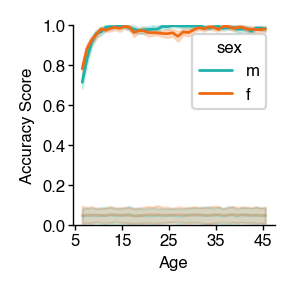

In [6]:
# Plot accuracy scores
fig=plt.figure(figsize=(1.3, 1.3))

# Plot shuffled results
sns.lineplot(data=shuffle_df, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], alpha=0.25, legend=False, errorbar=('sd', 2))

# Plot original results
sns.lineplot(data=results_df, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], errorbar=('sd', 2))

plt.xlabel('Age')
plt.ylabel('Accuracy Score')
plt.ylim([0, 1])
plt.xticks([5,15,25,35,45])
sns.despine()
plt.show()

In [7]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '07_25_indv_decoder_longv2.pdf')

In [8]:
## last data point prediction

In [12]:
# Parameters
N_SPLIT = 5
N_REP = 20
N_SHUFFLE = 100
WINDOW_SIZE = 8
N_TEST_SESSIONS = 8

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=10, kernel='linear'))
])

def rolling_window_classification(df, pipeline, window_size=8, n_test_sessions=2):
    results = []
    shuffle_results = []
    ages = df.index.get_level_values('age').unique()
    
    # Identify the last n sessions for testing
    test_sessions = ages[-n_test_sessions:]
    
    for i in tqdm(range(len(ages) - window_size - n_test_sessions + 1), desc="Rolling Window Classification Progress"):
        window_ages = ages[i:i + window_size]
        window_data = df.loc[df.index.get_level_values('age').isin(window_ages)]
        center_age = np.mean(window_ages)
        
        # Get test data (always the same last n sessions)
        test_data = df.loc[df.index.get_level_values('age').isin(test_sessions)]
        
        for sex in np.unique(window_data.index.get_level_values('sex')):
            train_data = window_data[window_data.index.get_level_values('sex') == sex]
            X_train = train_data.values
            y_train = train_data.index.get_level_values('mouse')
            
            test_data_sex = test_data[test_data.index.get_level_values('sex') == sex]
            X_test = test_data_sex.values
            y_test = test_data_sex.index.get_level_values('mouse')
            
            # Original classification
            for j in range(N_REP):
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)
                results.append((center_age, accuracy_score(y_test, y_pred), sex))
             
            # Shuffled classifications
            for j in range(N_SHUFFLE):
                y_train_shuffled = np.random.permutation(y_train)
                y_test_shuffled = np.random.permutation(y_test)
                pipeline.fit(X_train, y_train_shuffled)
                y_pred_shuff = pipeline.predict(X_test)
                shuffle_results.append((center_age, accuracy_score(y_test_shuffled, y_pred_shuff), sex))
    
    return results, shuffle_results

# Run the rolling window classification for combined data
results, shuffle_results = rolling_window_classification(combined_df, pipeline, window_size=WINDOW_SIZE, n_test_sessions=N_TEST_SESSIONS)
results_df = pd.DataFrame(results, columns=['age', 'accuracy', 'sex'])
shuffle_df = pd.DataFrame(shuffle_results, columns=['age', 'accuracy', 'sex'])

Rolling Window Classification Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:25<00:00,  2.76s/it]


In [13]:
temp = results_df.query('sex=="m"')
temp['age'].value_counts()

age
6.500     20
22.500    20
36.500    20
35.500    20
34.500    20
33.500    20
32.500    20
31.375    20
30.250    20
29.125    20
28.000    20
26.875    20
25.750    20
24.625    20
23.500    20
21.500    20
7.500     20
20.500    20
19.500    20
18.500    20
17.500    20
16.500    20
15.500    20
14.500    20
13.500    20
12.500    20
11.500    20
10.500    20
9.500     20
8.500     20
37.500    20
Name: count, dtype: int64

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

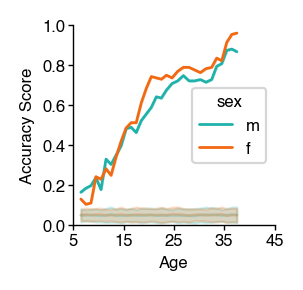

In [15]:
# Plot accuracy scores
fig=plt.figure(figsize=(1.3, 1.3))

# Plot shuffled results
sns.lineplot(data=shuffle_df, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], alpha=0.25, legend=False, errorbar=('sd', 2))

# Plot original results
sns.lineplot(data=results_df, x='age', y='accuracy', hue='sex', hue_order=['m','f'], 
             palette=['#20B2AA', '#f16913'], errorbar=('sd', 2))

plt.xlabel('Age')
plt.ylabel('Accuracy Score')
plt.ylim([0, 1])
plt.xticks([5,15,25,35,45])
sns.despine()
plt.show()

In [11]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '07_25_indv_decoder_longv2_TEST_LAST_POINT.pdf')